# Goals:
create a psql database, load our information in, query the info we need, then perform hypothesis testing and make a final recommendation.

In [1]:
#import our libraries
import psycopg2
import csv
import glob
import numpy as np 
import pandas as pd
from scipy import stats
from sqlalchemy import create_engine

In [2]:
#create the database

# ! createdb mod2project


In [3]:
#connect to the database and make a cursor
conn = psycopg2.connect("dbname=mod2project")
cur = conn.cursor()

### Make the tables to hold our data:

In [4]:
#set up our SQL tables
create_query_1 = """
CREATE TABLE course_offerings(
  uuid text
, course_uuid text 
, term_code integer
, name text
)
"""

create_query_2 = """
CREATE TABLE courses(
  uuid text 
, name text 
, number integer
)
"""

create_query_3 = """
CREATE TABLE grade_distributions(
  course_offering_uuid text
, section_number text 
, a_count integer
, ab_count integer
, b_count integer
, bc_count integer
, c_count integer
, d_count integer
, f_count integer
, s_count integer
, u_count integer
, cr_count integer
, n_count integer
, p_count integer
, i_count integer
, nw_count integer
, nr_count integer
, other_count integer
)
"""

create_query_4 = """
CREATE TABLE instructors(
  id integer
, name text
)
"""

create_query_5 = """
CREATE TABLE rooms(
  uuid text
, facility_code text
, room_code text
)
"""

create_query_6 ="""
CREATE TABLE schedules(
  uuid text
, start_time integer
, end_time integer
, mon text
, tues text
, wed text
, thurs text
, fri text
, sat text
, sun text
)
"""

create_query_7 = """
CREATE TABLE sections(
  uuid text
, course_offering_uuid text
, section_type text
, number text
, room_uuid text
,schedule_uuid text
)
"""

create_query_8 = """
CREATE TABLE subject_memberships(
  subject_code integer
, course_offering_uuid text
)
"""

create_query_9 = """
CREATE TABLE subjects(
  code text
, name text
, abbreviation text
)
"""

create_query_10 = """
CREATE TABLE teachings(
  instructor_id integer
, section_uuid text
)
"""

In [5]:
#get the names and locations of our datafiles
csvs_for_table = glob.glob('raw_data/*.csv')

In [6]:
#make a list of our queries
queries_list = [create_query_1,create_query_2,create_query_3,create_query_4
               ,create_query_5,create_query_6,create_query_7
               ,create_query_8,create_query_9,create_query_10]

In [7]:
#extract table names from our file names
table_names = [x.split('/')[1][:-4] for x in csvs_for_table]

In [8]:
#loop through our queries list and execute them

# for query in queries_list:
#     cur.execute(query)
#     conn.commit()

### Insert our data into our tables:

In [9]:
# #loop through our table names and indexes
# for q_num, table_name in enumerate(table_names):
    
#     #extract values from our first queries to use
#     #in our insert statements below
#     fields = tuple(line.strip(", ").split()[0] for 
#                    line in queries_list[q_num].split('\n')[2:-2])
    
#     #set up our insert statements
#     query = f'''
#     INSERT INTO {table_name}
#     ({', '.join(fields)})
#     VALUES ({', '.join('%s' for _ in range(len(fields)))})
#     '''
        
    
#     #open each file and insert it's values row
#     #by row into the appropriate tables
#     with open(csvs_for_table[q_num], 'r') as file:
#         reader = csv.reader(file)
#         next(reader)  # Skip the header row.
#         for row in reader:
#             cur.execute(
#                 query,
#                 row
#             )
#             conn.commit()
            
#         #check where we're having problems
#         print(table_name,'still good')

In [10]:
# remove this before the final release
# conn.rollback()


### Make the query for our information:

In [11]:
#set up a sqlalchemy engine

engine = create_engine("postgresql:///mod2project", echo=True)


In [12]:
#build our query
q = """
SELECT DISTINCT
  sub_m.subject_code
, sub_j.name AS sub_j_name
, grade_d.a_count
, grade_d.ab_count
, grade_d.b_count
, grade_d.bc_count
, grade_d.c_count
, grade_d.d_count
, grade_d.f_count
, grade_d.s_count
, grade_d.u_count
, grade_d.cr_count
, grade_d.n_count
, grade_d.p_count
, grade_d.i_count
, grade_d.nw_count
, grade_d.nr_count
, grade_d.other_count
, sch.start_time
, sch.end_time
,

  CASE
        WHEN term_code BETWEEN 1063 AND 1073 THEN '2006'
        WHEN term_code BETWEEN 1073 AND 1083 THEN '2007'
        WHEN term_code BETWEEN 1083 AND 1093 THEN '2008'
        WHEN term_code BETWEEN 1093 AND 1103 THEN '2009'
        WHEN term_code BETWEEN 1103 AND 1113 THEN '2010'
        WHEN term_code BETWEEN 1113 AND 1123 THEN '2011'
        WHEN term_code BETWEEN 1123 AND 1133 THEN '2012'
        WHEN term_code BETWEEN 1133 AND 1143 THEN '2013'
        WHEN term_code BETWEEN 1143 AND 1153 THEN '2014'
        WHEN term_code BETWEEN 1153 AND 1163 THEN '2015'
        WHEN term_code BETWEEN 1163 AND 1173 THEN '2016'
        WHEN term_code BETWEEN 1173 AND 1183 THEN '2017'
        ELSE 'the_world_is_over'
    END AS Year
    

FROM grade_distributions AS grade_d

JOIN sections sect
  ON sect.course_offering_uuid = grade_d.course_offering_uuid
  AND sect.number = grade_d.section_number

JOIN subject_memberships sub_m
  ON grade_d.course_offering_uuid = sub_m.course_offering_uuid
  

JOIN course_offerings cor_o
  ON cor_o.uuid = grade_d.course_offering_uuid


JOIN schedules sch
  ON sect.schedule_uuid = sch.uuid
  
JOIN subjects sub_j
  ON cast(sub_m.subject_code as text) = cast(sub_j.code as text)

"""

In [13]:
#put our query into a dataframe
df_join = pd.read_sql_query(q,con=engine)

2019-05-10 09:20:16,964 INFO sqlalchemy.engine.base.Engine select version()
2019-05-10 09:20:16,965 INFO sqlalchemy.engine.base.Engine {}
2019-05-10 09:20:16,968 INFO sqlalchemy.engine.base.Engine select current_schema()
2019-05-10 09:20:16,969 INFO sqlalchemy.engine.base.Engine {}
2019-05-10 09:20:16,972 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-05-10 09:20:16,973 INFO sqlalchemy.engine.base.Engine {}
2019-05-10 09:20:16,977 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-05-10 09:20:16,978 INFO sqlalchemy.engine.base.Engine {}
2019-05-10 09:20:16,980 INFO sqlalchemy.engine.base.Engine show standard_conforming_strings
2019-05-10 09:20:16,984 INFO sqlalchemy.engine.base.Engine {}
2019-05-10 09:20:16,987 INFO sqlalchemy.engine.base.Engine 
SELECT DISTINCT
  sub_m.subject_code
, sub_j.name AS sub_j_name
, grade_d.a_count
, grade_d.ab_count
, grade_d.b_count
, grade_d.bc_count
, g

### Define what is and isn't STEM and create dataframes for each:

In [14]:
#create a unique set of course names
all_courses = set(df_join.sub_j_name)

In [15]:
#make a list of humanites
humanities = {'African Languages and Literature', 'Afro-American Studies', 
              'American Indian Studies', 'Art Department', 'Anthropology'
              'Art Education (Department of Art)', 'Art History', 'Asian American Studies',
              'Chicana/o and Latina/o Studies', 'Classics', 'Collaborative Nursing Program',
              'Communication Arts','Communication Sciences and Disorders', 'Community and Environmental Sociology',
              'Comparative Literature', 'Consumer Science', 'Counseling Psychology', 'Curriculum and Instruction',
              'Dance', 'Design Studies', 'ENGLISH', 'East Asian Area Studies', 'East Asian Languages and Literature',
              'Economics', 'Educational Leadership and Policy Analysis', 'Educational Policy Studies',
              'Educational Psychology', 'Emergency Medicine', 'Engineering Professional Development',
              'English', 'English as a Second Language', 'Entomology', 'Environmental Studies - Gaylord Nelson Institute',
              'FAMILY AND CONSUMER COMMUNICATIONS', 'Family Medicine', 'Farm & Industry Short Course',
              'Finance, Investment and Banking', 'Folklore Program', 'Forest and Wildlife Ecology',
              'French (French and Italian)', 'Gender and Women’s Studies', 'General Business',
              'Geography', 'German', 'Greek (Classics)', 'HEBREW', 'Hebrew-Biblical', 'Hebrew-Modern',
              'History', 'History of Science', 'Horticulture', 'Human Development and Family Studies',
              'Human Oncology', 'INDUSTRIAL RELATIONS', 'Integrated Arts', 'Integrated Liberal Studies',
              'Integrated Science', 'Interdisciplinary Courses (CALS)', 'Interdisciplinary Courses (L&S)',
              'Interdisciplinary Courses (SOHE)', 'International Business', 'International Studies',
              'Italian (French and Italian)', 'Jewish Studies', 'Journalism and Mass Communication',
              'Kinesiology', 'La Follette School of Public Affairs',  'Landscape Architecture',
              'Languages and Cultures of Asia', 'Languages and Cultures of Asia - Languages',
              'Latin (Classics)', 'Latin American, Caribbean, and Iberian Studies',
              'Law','Legal Studies','Library and Information Studies',
              'Life Sciences Communication', 'Linguistics', 'Literature in Translation',
              'Management and Human Resources', 'Marketing', 'Medical History and Bioethics',
              'Medieval Studies','Music','Music-Performance','Nursing','Nutritional Sciences',
              'Occupational Therapy (Department of Kinesiology)',
              'Operations and Technology Management','PHYSICAL EDUC ACTIVITY PROGM',
              'PROFESSIONAL ORIENTATION', 'Pharmacy','Pharmacy Practice','Philosophy',
              'Physical Therapy','Physician Assistant Program','Political Science',
              'Portuguese (Spanish and Portuguese)','Psychiatry',
              'Real Estate and Urban Land Economics',
              'Rehabilitation Psychology and Special Education',
              'Religious Studies','Risk Management and Insurance',
              'Scandinavian Studies','Slavic (Slavic Languages)','Social Work',
              'Social and Administrative Pharmacy','Sociology','Soil Science',
              'Spanish (Spanish and Portuguese)','TRANSPORTATION AND PUBLIC UTILITIES',
              'Theatre and Drama','Therapeutic Science (Department of Kinesiology)',
              'Urban and Regional Planning','WILDLIFE ECOLOGY', 'Zoology'
 
              }

In [16]:
#remove the humanites from the course list
all_courses -= humanities

In [17]:
#set a STEM
STEM = all_courses

### Make a standard scale for grades:
Each grade is given an appropriate weight. <br>
We do this so we can more accurately find their means.

In [18]:
#make columns with grades adjusted for weight
df_join['weighted_a'] = df_join.a_count * 4
df_join['weighted_ab'] = df_join.ab_count * 3.5
df_join['weighted_b'] = df_join.b_count * 3
df_join['weighted_bc'] = df_join.bc_count * 2.5
df_join['weighted_c'] = df_join.c_count * 2
df_join['weighted_d'] = df_join.c_count * 1
df_join['weighted_f'] = df_join.c_count * 0

In [19]:
#adding the grades together
sum_grades = (df_join.weighted_a + 
              df_join.weighted_ab + 
              df_join.weighted_b + 
              df_join.weighted_bc + 
              df_join.weighted_c +
              df_join.weighted_d + 
              df_join.weighted_f)

df_join['sum_of_grades'] = sum_grades

In [20]:
#adding the student counts together
student_counts = (df_join.a_count +
                  df_join.ab_count +
                  df_join.b_count +
                  df_join.bc_count +
                  df_join.c_count + 
                  df_join.d_count +
                  df_join.f_count +
                  df_join.s_count +
                  df_join.u_count + 
                  df_join.cr_count +
                  df_join.n_count + 
                  df_join.p_count + 
                  df_join.i_count +
                  df_join.nw_count +
                  df_join.nr_count +
                  df_join.other_count)

df_join['student_count'] = student_counts

In [21]:
a_f_count = (df_join.a_count +
                  df_join.ab_count +
                  df_join.b_count +
                  df_join.bc_count +
                  df_join.c_count + 
                  df_join.d_count +
                  df_join.f_count)
df_join['a_f_count'] = a_f_count

In [22]:
#make a ratio of mean grade per class
df_join['grade_ratio'] = df_join.sum_of_grades/ df_join.a_f_count

#make ratio grade for each student
df_STEM = df_join.loc[df_join.sub_j_name.isin(STEM)]
STEM_grade = df_STEM.grade_ratio.sum()/df_STEM.grade_ratio.count()

df_humanites = df_join.loc[df_join.sub_j_name.isin(humanities)]
humanites_grade = df_humanites.grade_ratio.sum()/df_humanites.grade_ratio.count()

In [23]:
df_STEM.head()

,subject_code,sub_j_name,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,s_count,...,weighted_ab,weighted_b,weighted_bc,weighted_c,weighted_d,weighted_f,sum_of_grades,student_count,a_f_count,grade_ratio
0,102,Air Force Aerospace Studies,0,0,0,0,0,0,0,0,...,0.0,0,0.0,0,0,0,0.0,0,0,NaN
1,102,Air Force Aerospace Studies,0,0,0,0,0,0,0,0,...,0.0,0,0.0,0,0,0,0.0,0,0,NaN
2,102,Air Force Aerospace Studies,0,0,0,0,0,0,0,0,...,0.0,0,0.0,0,0,0,0.0,0,0,NaN
3,102,Air Force Aerospace Studies,1,2,4,3,1,0,0,0,...,7.0,12,7.5,2,1,0,33.5,11,11,3.045455
4,102,Air Force Aerospace Studies,1,4,1,0,0,0,0,0,...,14.0,3,0.0,0,0,0,21.0,7,6,3.500000


In [24]:
df_humanites.head()

,subject_code,sub_j_name,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,s_count,...,weighted_ab,weighted_b,weighted_bc,weighted_c,weighted_d,weighted_f,sum_of_grades,student_count,a_f_count,grade_ratio
103,104,African Languages and Literature,0,0,0,0,0,0,0,0,...,0.0,0,0.0,0,0,0,0.0,0,0,NaN
104,104,African Languages and Literature,0,0,0,0,0,0,0,0,...,0.0,0,0.0,0,0,0,0.0,0,0,NaN
105,104,African Languages and Literature,0,0,0,0,0,0,0,0,...,0.0,0,0.0,0,0,0,0.0,0,0,NaN
106,104,African Languages and Literature,0,0,0,0,0,0,0,0,...,0.0,0,0.0,0,0,0,0.0,0,0,NaN
107,104,African Languages and Literature,0,0,0,0,0,0,0,0,...,0.0,0,0.0,0,0,0,0.0,0,0,NaN



## Now for our conditions:
<ol>
	<li>STEM education:
	Jenkins wants a school that has STEM courses that are on par or better than courses in the humanities</li>
	<li>STEM progression:
	Jenkins is concerned with the future of education, especially in STEM courses. We are looking for a school that has shown improvement in their STEM departents during recent years</li>
	<li>Class duration:
	Jenkins is interested in the effect of time spent in class. Do Classes with longer sessions produce better grades?</li>
	<li>Consistent improvement:
	Jenkins wants to be sure his donation will go to good use. He is looking for a school with consistent results for each and every student, and a proven record of updating and refining courses for the best results.</li>
</ol>


### Condition 1: do STEM courses get worse grades than the humanities?
$H_0$: humanities mean grade = STEM mean grade <br>
$H_A$: humanities mean grade > STEM mean grade <br>
we will be using alpha of 0.05 for our hypothesis test

In [25]:
alpha = 0.05

#find statistics for a hypothesis test
STEM_mean = df_STEM.grade_ratio.mean()
STEM_std = df_STEM.grade_ratio.std()

humanities_mean = df_humanites.grade_ratio.mean()

#perform hypothesis test
z_score = (humanities_mean - STEM_mean)/ STEM_std

STEM_vs_hum_results = stats.norm.sf(z_score)
STEM_vs_hum_results

0.3740595213057142

In [26]:
STEM_vs_hum_results < alpha

False

#####  based on our findings, we cannot at this time reject $H_0$

### do STEM mean grades get better as time goes on?
$H_0$: STEM mean grades in 2007 = STEM mean grades in 2017 <br>
$H_A$: STEM mean grades in 2007 != STEM mean grades in 2017 <br>
once again we will be using alpha of 0.05

In [27]:
#find statistics for a hypothesis test
STEM_o_seven_mean = df_STEM.loc[df_STEM.year == '2007'].grade_ratio.mean()
STEM_o_seven_std = df_STEM.loc[df_STEM.year == '2007'].grade_ratio.std()
STEM_seventeen_mean = df_STEM.loc[df_STEM.year == '2017'].grade_ratio.mean()

#perform hypothesis test
STEM_z_score = ((STEM_seventeen_mean - STEM_o_seven_mean)/
                STEM_o_seven_std)

STEM_decade_results = stats.norm.sf(STEM_z_score)
STEM_decade_results

0.4467094049602883

In [28]:
STEM_decade_results < alpha

False

#####  based on our findings, we cannot at this time reject $H_0$

### does the humanites mean grade get better as time goes on?
$H_0$: humanities mean grades in 2007 = humanities mean grades in 2017 <br>
$H_A$: humanities mean grades in 2007 != humanities mean grades in 2017 <br>
yet again we will be using alpha of 0.05

In [29]:
#find statistics for a hypothesis test
hum_o_seven_mean = df_humanites.loc[df_humanites.year == '2007'].grade_ratio.mean()
hum_o_seven_std = df_humanites.loc[df_humanites.year == '2007'].grade_ratio.std()
hum_seventeen_mean = df_humanites.loc[df_humanites.year == '2017'].grade_ratio.mean()


#perform hypothesis test
hum_z_score = ((hum_seventeen_mean -
                      hum_o_seven_mean)/
                     hum_o_seven_std)

hum_decade_results = stats.norm.sf(hum_z_score)
hum_decade_results

0.3995269595910631

In [30]:
hum_decade_results < alpha

False

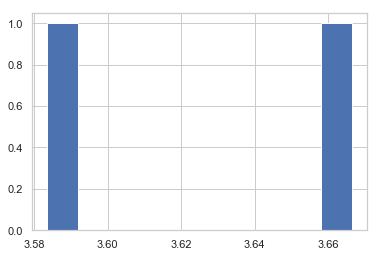

In [163]:
x = (hum_o_seven_mean, hum_seventeen_mean)
plt.hist(x);

#####  based on our findings, we cannot at this time reject $H_0$

### do longer classes have higher mean grades than shorter classes?
$H_0$: longer class mean grade = shorter class mean grade <br>
$H_A$: longer class mean grade > shorter class mean grade <br>
we will be using alpha of 0.05

In [31]:
#make new column to measure the length of time in minutes
df_join['class_duration'] = (df_join.end_time - 
                             df_join.start_time)

In [32]:
#find a good short and long class time to use
#we settle with 50 minutes for short and
#120 minutes for long
df_join.class_duration.unique()

array([ 50,  75,   0,  85, 100,  80,  60, 120, 200, 150, 115, 160, 180,
       110,  90, 105,  55, 130, 155, 170, 145, 210, 165, 140,  70, 480,
       240, 510, 540,  95, 660, 720,  72, 300, 360, 520, 420, 270, 195,
       450,  45, 226, 125, 190, 175, 135, 245, 265, 250,  25, 225,   5,
       255, 189, 215,  65, 570, 435, 465, 205,  30, 390, 810, 330, 181,
        64,  40, 220, 185, 600,  88, 119, 555, 539, 630, 500,  35, 113,
       770, 325, 340, 690, 525, 645])

In [33]:
#find statistics for a hypothesis test
fifty_mean = df_join.loc[df_join.class_duration == 50].grade_ratio.mean()
fifty_std = df_join.loc[df_join.class_duration == 50].grade_ratio.std()
one_twenty_mean = df_join.loc[df_join.class_duration == 120].grade_ratio.mean()

#perform hypothesis test
class_duration_z_score = ((one_twenty_mean -
                          fifty_mean)/fifty_std)
class_hypo_results = stats.norm.sf(class_duration_z_score)
class_hypo_results

0.21377535441649897

In [157]:
len(df_join.loc[df_join.class_duration == 50].grade_ratio)

34273

In [158]:
#find statistics for a hypothesis test
fifty_mean = df_join.loc[df_join.class_duration == 50].grade_ratio.mean()
fifty_std = df_join.loc[df_join.class_duration == 50].grade_ratio.std()
one_twenty_mean = df_join.loc[df_join.class_duration == 120].grade_ratio.mean()
one_twenty_std = df_join.loc[df_join.class_duration == 120].grade_ratio.std()


#perform hypothesis test
class_size_t_score = ((one_twenty_mean - fifty_mean)/
                      math.sqrt(((one_twenty_std**2)/7556)+
                                ((fifty_std**2)/34273)))


In [159]:
class_size_t_score

70.49929543812506

In [34]:
class_hypo_results < alpha

False

#####  based on our findings, we cannot at this time reject $H_0$

### do larger classes have lower mean grades than shorter classes?
$H_0$: larger class mean grade = smaller class mean grade <br>
$H_A$: larger class mean grade != smaller class mean grade <br>
we will be using alpha of 0.05

In [75]:
#make new column to measure the size of classes
size_grades = df_join[['student_count', 'grade_ratio']]

In [148]:
size_grades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117352 entries, 0 to 117351
Data columns (total 2 columns):
student_count    117352 non-null int64
grade_ratio      102458 non-null float64
dtypes: float64(1), int64(1)
memory usage: 1.8 MB


In [76]:
size_grades_final = size_grades.groupby(['student_count']).mean().reset_index()

In [77]:
print('The 25% quantile class size is ' + f"{size_grades_final['student_count'].quantile(.25)}")
print('The 50% quantile class size is ' + f"{size_grades_final['student_count'].quantile(.50)}")
print('The 75% quantile class size is ' + f"{size_grades_final['student_count'].quantile(.75)}")

The 25% quantile class size is 127.5
The 50% quantile class size is 255.0
The 75% quantile class size is 382.5


Based on this information, we are going to designate classes over 255 students a large a class size for this university. 

In [166]:
classes_large_mean = size_grades_final.loc[size_grades_final['student_count'] >= 255].mean()[1]

In [167]:
classes_large_mean

3.214740942278443

In [105]:
classes_large_std = size_grades_final.loc[size_grades_final['student_count'] >= 255].std()[1]

In [106]:
classes_large_std 

0.28089690558655256

In [107]:
classes_small_mean = size_grades_final.loc[size_grades_final['student_count'] < 255].mean()[1]

In [108]:
classes_small_mean

3.334769081144078

In [124]:
size_grades_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511 entries, 0 to 510
Data columns (total 2 columns):
student_count    511 non-null int64
grade_ratio      510 non-null float64
dtypes: float64(1), int64(1)
memory usage: 8.1 KB


In [109]:
classes_small_std = size_grades_final.loc[size_grades_final['student_count'] < 255].std()[1]

In [110]:
classes_small_std

0.15403641524074818

In [169]:
size_grades_final.loc[size_grades_final['student_count'] < 255].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 255 entries, 0 to 254
Data columns (total 2 columns):
student_count    255 non-null int64
grade_ratio      254 non-null float64
dtypes: float64(1), int64(1)
memory usage: 6.0 KB


In [170]:
import math

#find statistics for a hypothesis test
small_mean = classes_small_mean
small_std = classes_small_std
large_mean = classes_large_mean
large_std = classes_large_std

#perform hypothesis test
class_size_t_score = ((large_mean - small_mean)/
                      math.sqrt(((classes_large_std**2)/254)+
                                ((classes_small_std**2)/254)))


class_size_t_score

#stats.t.sf(class_size_t_score,1576,115759)

-5.971207385553882

#####  based on our findings, we cannot at this time reject $H_0$

In [45]:
import seaborn as sns

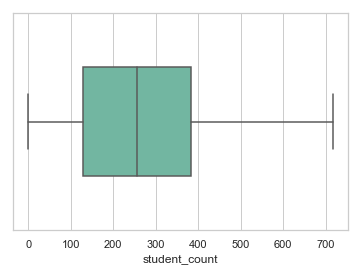

In [46]:
sns.set(style="whitegrid")
ax = sns.boxplot(x=size_grades_final['student_count'], 
                 orient="h", palette="Set2", width=0.5)


In [47]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [48]:
class_time_hours = df_join['class_duration'].divide(60)

(array([8.1859e+04, 2.4819e+04, 7.5230e+03, 5.6300e+02, 8.4000e+01,
        2.8100e+02, 5.0600e+02, 3.3300e+02, 1.3820e+03, 2.0000e+00]),
 array([ 0.  ,  1.35,  2.7 ,  4.05,  5.4 ,  6.75,  8.1 ,  9.45, 10.8 ,
        12.15, 13.5 ]),
 <a list of 10 Patch objects>)

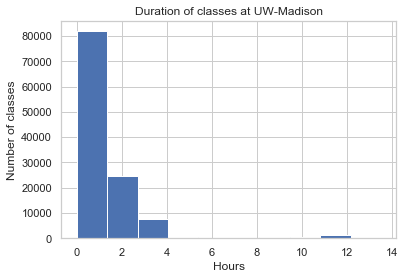

In [49]:
plt.xlabel('Hours')
plt.ylabel('Number of classes')
plt.title('Duration of classes at UW-Madison')
plt.hist(class_time_hours)

/Users/sherzyang/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/sherzyang/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


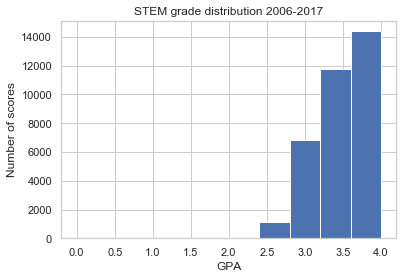

In [50]:
plt.xlabel('GPA')
plt.ylabel('Number of scores')
plt.title('STEM grade distribution 2006-2017')
plt.hist(df_STEM.grade_ratio);

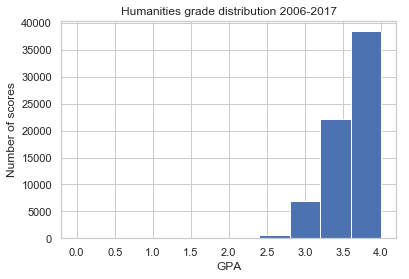

In [51]:
plt.xlabel('GPA')
plt.ylabel('Number of scores')
plt.title('Humanities grade distribution 2006-2017')
plt.hist(df_humanites.grade_ratio);